In [1]:
from everywhereml.data import Dataset
from everywhereml.data.collect import SerialCollector

import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from random import shuffle
from sklearn.manifold import TSNE

1. Read 10-second 4000+ Hz Data

In [2]:
def getJsonFileNamesInFolder(path2jsonFiles: str) -> Iterable[str]:
    res = glob.glob(path2jsonFiles)
    return res

def parseJsonFile(filename: str, track_dict: dict) -> dict:
    # start_t = time.perf_counter()
    file = open(filename)
    content = json.load(file)
    #print(content)

    label = content["label"]
    #print(content["label"])
    if label not in track_dict:
        track_dict[label] = 0
    
    track_dict[label] = track_dict[label] + 1
    #print("number of ", label, track_dict[label])

    file.close()
    # end_t = time.perf_counter()
    return content, track_dict

def parseJsonFiles(filenames: Iterable[str], maximumNumberOfFilesPerLabel = -1) -> dict:
    start_t = time.perf_counter()
    track_dict: dict = dict()



    results = []
    #print("parseJsonFiles", filenames)
    #print("type filenames", type(filenames))

    shuffle(filenames)
    filenames_shuffled = filenames


    #print("shuffled_filenames", filenames_shuffled)

    # with Pool() as pool:
    #     results = pool.map(parseJsonFile, filenames)
    
    for filename in filenames_shuffled:
        #print("filename", filename)
        temp,track_dict = parseJsonFile(filename, track_dict)
        
        if(maximumNumberOfFilesPerLabel == -1):
            results.append(temp)

        if(track_dict[temp["label"]] <= maximumNumberOfFilesPerLabel):
            results.append(temp)

        if(len(track_dict.keys()) == 9):
            doBreak = True
            for key in track_dict:
                if track_dict[key] < maximumNumberOfFilesPerLabel:
                    doBreak = False
            if(doBreak):
                break # break as soon as each class has reached the maximum number of datapoints

        # for filename, content, duration in results:
        #     print(f"{filename} completed in {duration:.2f}s")
    end_t = time.perf_counter()
    total_duration = end_t - start_t
    print(f"etl took {total_duration:.2f}s total")
    return results

def createXandY(path2jsonFiles: str, maximumNumberOfFilesPerLabel = -1) -> Tuple[np.ndarray, np.ndarray]:
    # (filename, dict)
    jsonFilePaths : str = getJsonFileNamesInFolder(path2jsonFiles)
    print(jsonFilePaths)
    parsedFilesList = parseJsonFiles(jsonFilePaths, maximumNumberOfFilesPerLabel=maximumNumberOfFilesPerLabel)
    
    numberOfFiles = int(len(parsedFilesList))

    

    print(type(parsedFilesList[0]))
    
    
    
    sampleRate = int(parsedFilesList[0]["sampleRate"])
    durationInSeconds = int(parsedFilesList[0]["durationInSeconds"])
    datapointsPerChannel = sampleRate*durationInSeconds
    numberOfChannels = 3

    X = np.empty((numberOfFiles,datapointsPerChannel, numberOfChannels)) # (numberOfFiles, sampleRate*durationInSeconds, numberOfChannels)
    y = np.empty((numberOfFiles,),dtype=object) #(numberOfFiles, 1)

    for idx, parsedFile in enumerate(parsedFilesList):
        
        X_temp = np.empty((datapointsPerChannel, numberOfChannels))
        
        X_temp[:,0] = parsedFile["x"]
        X_temp[:,1] = parsedFile["y"]
        X_temp[:,2] = parsedFile["z"]

        X[idx] = X_temp

        y[idx] = parsedFile["label"]




    return X,y 




In [3]:
X, y = createXandY("../data/traintest/*.json", maximumNumberOfFilesPerLabel=50)
X_eval, y_eval = createXandY("../data/evaluation/*.json", maximumNumberOfFilesPerLabel=5)
#51 seconds

['../data/traintest/1661470457342_to_1661470578339_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662041197516_to_1662466208815_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663261204154_to_1663261325151_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661436286942_to_1661436553639_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663249043654_to_1663249164651_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662653424850_to_1662653545847_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661492346242_to_1661492467239_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662483197218_to_1662483318215_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663065600966_to_1663065721963_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/16625606

In [4]:
def convertLabelToNumeric(y):
    label_lockup_dict = dict.fromkeys(np.unique(y))
    for idx, key in enumerate(label_lockup_dict):
        label_lockup_dict[key] = idx
        print(key, idx)

    for idx, label in enumerate(y):
        y[idx] = label_lockup_dict[label]

    y = y.astype(int)
    return y

In [5]:
y = convertLabelToNumeric(y)
y_eval = convertLabelToNumeric(y_eval)

GLT_Rollwagen 0
Gehen 1
HebenSenken 2
Hubwagen 3
Kiste liegt 4
Rollenbahn 5
Rolltisch 6
Sackkarre 7
vert. drehen 8
GLT_Rollwagen 0
Gehen 1
HebenSenken 2
Hubwagen 3
Kiste liegt 4
Rollenbahn 5
Rolltisch 6
Sackkarre 7
vert. drehen 8


In [6]:
unique, frequency = np.unique(y, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1 2 3 4 5 6 7 8]
Frequency Values: [50 50 50 50 50 50 50 50 50]


In [7]:
print(X.shape, y.shape)

(450, 40000, 3) (450,)


2. Remove outliers

In [8]:
def deleteOutliers(X, y):
    badIndices = findIllogicalValues(X, threshold=100)

    X = np.delete(X, badIndices, axis=0)
    y = np.delete(y, badIndices, axis=0)

    return X, y
    

def findIllogicalValues(arr,threshold):    
    indices = []
    
    for idx, recording in enumerate(arr):
        flag = False
        for datapoint in recording: 
            for i, channel in enumerate(datapoint):                
                temp = channel
                if (abs(temp) > threshold):                    
                    flag = True
        if(flag):
            indices.append(idx)
    return indices

In [9]:
X, y = deleteOutliers(X, y)
X_eval, y_eval = deleteOutliers(X_eval, y_eval)
# 1 minute

3. Apply Low-Pass filter

In [10]:
import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)

    return filtered_accel_data

In [11]:
X = applyLowPassFilter(X)
X_eval = applyLowPassFilter(X_eval)

In [12]:
print(X.shape, y.shape)

(449, 40000, 3) (449,)


4. Transform into 1? second recordings

In [13]:
def reduceRecordingDuration(X, y):
    # Define the input parameters
    recording_length = 10  # in seconds
    sampling_rate = 4000  # in Hz
    new_length = 3  # in seconds
    overlap = 0.1  # 10% overlap

    # Load the original recording data and labels (replace with your actual data)
    num_recordings = len(X)
    original_recordings = X#np.random.randn(num_recordings, recording_length * sampling_rate, 3)
    original_labels = y

    # Calculate the number of new samples and new recordings
    num_new_samples = new_length * sampling_rate
    overlap_samples = int(num_new_samples * overlap)
    num_new_recordings = int(np.floor((recording_length * sampling_rate - num_new_samples) / overlap_samples) + 1)

    # Initialize the new recordings and labels arrays
    new_recordings = np.zeros((num_recordings * num_new_recordings, num_new_samples, 3))
    new_labels = np.empty((num_recordings * num_new_recordings,),dtype=object)

    # Split the original recordings and labels into the new recordings and labels
    for i in range(num_recordings):
        for j in range(num_new_recordings):
            start = j * overlap_samples
            end = start + num_new_samples
            new_recordings[i*num_new_recordings+j] = original_recordings[i, start:end]
            new_labels[i*num_new_recordings+j] = original_labels[i]
    return new_recordings, new_labels

In [14]:
X, y = reduceRecordingDuration(X, y)
X_eval, y_eval = reduceRecordingDuration(X_eval, y_eval)

In [15]:
print(X.shape, y.shape)
print(X_eval.shape, y_eval.shape)

(10776, 12000, 3) (10776,)
(1080, 12000, 3) (1080,)


5. Combine all recordings into one DataFrame with the columns ["ax", "ay", "az", "target"]

In [16]:
import pandas as pd

In [17]:

def expand_labels(labels, X):
    # Reshape the input array to have shape (1000, 1)
    labels_reshaped = labels.reshape((-1, 1))

    # Repeat each label 4000 times along the second axis to create a new array with shape (1000, 4000)
    labels_repeated = np.repeat(labels_reshaped, X.shape[1], axis=1)

    # Flatten the array to create a new array with shape (4000000,)
    result = labels_repeated.flatten()

    return result

In [18]:
print(X.shape, y.shape)

(10776, 12000, 3) (10776,)


In [19]:
y = expand_labels(y,X)
y_eval = expand_labels(y_eval, X_eval)

In [20]:
# (180453, 4000, 3) -> (180453 * 4000, 3)
def mergeIndividualSamples(X):
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
    return X

X = mergeIndividualSamples(X)
X_eval = mergeIndividualSamples(X_eval)



In [21]:
print(X.shape, y.shape)
print(X_eval.shape, y_eval.shape)

(129312000, 3) (129312000,)
(12960000, 3) (12960000,)


In [22]:
def combine_to_dataframe(X, y):
    # Create a dictionary with keys 'x0', 'x1', 'x2', and 'y'
    data_dict = {'ax': X[:, 0], 'ay': X[:, 1], 'az': X[:, 2], 'target': y}

    # Convert the dictionary to a DataFrame
    result = pd.DataFrame(data_dict)

    return result

In [23]:
dataDF = combine_to_dataframe(X, y)
dataDF_eval = combine_to_dataframe(X_eval, y_eval)

In [24]:
dataDF.describe()

,ax,ay,az
count,1.293120e+08,1.293120e+08,1.293120e+08
mean,-2.253983e-02,-1.663622e-02,-8.812079e-01
std,3.005570e-01,1.524244e-01,3.565179e-01
min,-9.686232e+00,-3.294976e+00,-1.108436e+01
25%,-1.269579e-01,-7.175389e-02,-9.968588e-01
50%,-4.975469e-03,-1.410936e-02,-9.019435e-01
75%,1.176255e-01,3.975260e-02,-7.412572e-01
max,7.907509e+00,4.119064e+00,8.063403e+00


In [25]:
dataDF_eval.head()

,ax,ay,az,target
0,0.117741,0.018370,-0.826741,2
1,0.117471,0.019231,-0.833397,2
2,0.113903,0.020593,-0.835522,2
3,0.109057,0.021676,-0.834431,2
4,0.107210,0.021994,-0.834794,2


6. Load DataFrame into everywhereml

In [26]:
import pandas as pd

import numpy as np
import pandas as pd

def downsample_data(df):
    # Determine the number of samples to keep for downsampling
    keep_samples = 4000 // 100
    
    # Extract the acceleration data and target labels from the dataframe
    data = df[['ax', 'ay', 'az']].values
    target = df['target'].values
    
    # Calculate the number of samples in the original data
    num_samples = data.shape[0]
    
    # Calculate the number of samples in the downsampled data
    num_samples_downsampled = num_samples // keep_samples
    
    # Reshape the acceleration data into a 2D array
    data_reshaped = data[:num_samples_downsampled*keep_samples,:].reshape(num_samples_downsampled, keep_samples, 3)
    
    # Downsample the data by taking the mean of each group of samples
    data_downsampled = np.mean(data_reshaped, axis=1)
    
    # Create a new dataframe with the downsampled data and target labels
    df_downsampled = pd.DataFrame(data_downsampled, columns=['ax', 'ay', 'az'])
    df_downsampled['target'] = target[:num_samples_downsampled*keep_samples:keep_samples]
    
    return df_downsampled

import pandas as pd

def downsample_acceleration_data(df):
    # calculate the number of samples in the original dataframe
    num_samples = df.shape[0]

    # calculate the number of samples in the downsampled dataframe
    num_downsampled_samples = num_samples // 40

    # create a new dataframe with the downsampled data
    df_downsampled = pd.DataFrame(columns=['ax', 'ay', 'az', 'target'])

    # downsample the acceleration data by taking the mean of every 40 samples
    for i in range(num_downsampled_samples):
        start_index = i * 40
        end_index = start_index + 40

        # select every 40th row and calculate the mean of the "ax", "ay", and "az" columns
        mean_values = df.iloc[start_index:end_index, :3].mean(axis=0)

        # select the "target" value from the first row of the 40-sample window
        target_value = df.iloc[start_index, df.columns.get_loc('target')]

        # add a new row to the downsampled dataframe with the mean "ax", "ay", "az", and "target" values
        df_downsampled.loc[i] = [mean_values['ax'], mean_values['ay'], mean_values['az'], target_value]

    return df_downsampled



def downsample_acceleration_data(df):
    # Resample the dataframe to 100 Hz using the mean of every 40 samples
    df_resampled = df.groupby(np.arange(len(df))//40).mean()
    
    # Set the index of the resampled dataframe to be the same as the original dataframe
    df_resampled.index = df.index
    
    # Return the resampled dataframe
    return df_resampled

In [27]:
downDF = downsample_data(dataDF)
downDF_eval = downsample_data(dataDF_eval)

In [28]:
len(downDF)

3232800

In [29]:
acc_dataset = Dataset.from_pandas(df=downDF, name="hi")
acc_dataset_eval = Dataset.from_pandas(df=downDF_eval, name="eval")

In [30]:
acc_dataset.describe()

,ax,ay,az,target,target_name
count,3.232800e+06,3.232800e+06,3.232800e+06,3232800,3232800
unique,4.445100e+05,4.445100e+05,4.445100e+05,9,9
top,-1.670718e-02,-1.544916e-02,-9.102901e-01,1,target_1
freq,1.000000e+01,1.000000e+01,1.000000e+01,360000,360000


In [31]:
from everywhereml.preprocessing import Pipeline, MinMaxScaler, Window, SpectralFeatures

# this is the frequency of your sensor
# change according to your hardware
sampling_frequency = 100
mean_gesture_duration_in_millis = 3000
window_length = sampling_frequency * mean_gesture_duration_in_millis // 1000

imu_pipeline = Pipeline(name='ContinousMotionPipeline', steps=[
    MinMaxScaler(),
    # shift can be an integer (number of samples) or a float (percent)
    Window(length=window_length, shift=1),
    # order can either be 1 (first-order features) or 2 (add second-order features)
    SpectralFeatures(order=2)
])

In [32]:
from pprint import pprint

pprint(imu_pipeline['SpectralFeatures'][0].feature_names)

['maximum',
 'minimum',
 'abs_maximum',
 'abs_minimum',
 'mean',
 'abs_energy',
 'mean_abs_change',
 'cid_ce',
 'std',
 'var',
 'count_above_mean',
 'count_below_mean',
 'first_position_of_max',
 'first_position_of_min',
 'max_count',
 'min_count',
 'has_large_std',
 'skew',
 'kurtosis',
 'variation_coefficient']


7. Apply Spectral-Features

In [33]:
acc_dataset.apply(imu_pipeline)
acc_dataset_eval.apply(imu_pipeline)

/usr/local/lib/python3.8/dist-packages/everywhereml/preprocessing/Window.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y = np.asarray([mode(window)[0][0] for window in dataset.y[idx]])
/usr/local/lib/python3.8/dist-packages/everywhereml/preprocessing/Window.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set

In [34]:
acc_dataset.describe()

,ax_maximum,ax_minimum,ax_abs_maximum,ax_abs_minimum,ax_mean,ax_abs_energy,ax_mean_abs_change,ax_cid_ce,ax_std,ax_var,...,az_count_below_mean,az_first_position_of_max,az_first_position_of_min,az_max_count,az_min_count,az_has_large_std,az_skew,az_kurtosis,az_variation_coefficient,target
count,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,...,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06,3.232501e+06
mean,7.261961e-01,5.509844e-01,7.261961e-01,5.509844e-01,6.374834e-01,4.157681e-01,2.048582e-02,1.473971e-03,3.825947e-02,2.446263e-03,...,1.285491e+02,1.366922e+02,1.365886e+02,4.603853e+01,4.184069e+01,1.885395e-01,-4.242456e-02,1.590037e+00,6.959031e-02,4.000231e+00
std,1.043180e-01,1.047464e-01,1.043180e-01,1.047464e-01,8.328691e-02,1.020490e-01,2.221180e-02,2.995291e-03,3.134449e-02,4.453882e-03,...,4.672121e+01,7.991200e+01,7.977723e+01,9.132141e+01,9.236279e+01,3.911424e-01,2.609445e-01,1.897242e+00,5.702114e-02,2.584866e+00
min,4.325340e-01,0.000000e+00,4.325340e-01,0.000000e+00,3.819967e-01,1.462375e-01,1.706040e-04,4.502252e-08,1.586640e-04,2.517425e-08,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-5.196805e+00,0.000000e+00,1.428820e-04,0.000000e+00
25%,6.762844e-01,4.936874e-01,6.762844e-01,4.936874e-01,6.300852e-01,4.009712e-01,5.028647e-03,5.598771e-05,1.765754e-02,3.117886e-04,...,1.320000e+02,6.800000e+01,6.800000e+01,2.000000e+00,1.000000e+00,0.000000e+00,-6.835738e-02,0.000000e+00,3.316657e-02,2.000000e+00
50%,7.152381e-01,5.721190e-01,7.152381e-01,5.721190e-01,6.441841e-01,4.155998e-01,1.321371e-02,3.367528e-04,3.002630e-02,9.015788e-04,...,1.440000e+02,1.360000e+02,1.360000e+02,7.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,1.555479e+00,5.558264e-02,4.000000e+00
75%,7.882819e-01,6.141714e-01,7.882819e-01,6.141714e-01,6.581441e-01,4.363610e-01,2.647017e-02,1.239980e-03,5.238145e-02,2.743817e-03,...,1.500000e+02,2.050000e+02,2.050000e+02,3.000000e+01,1.400000e+01,0.000000e+00,0.000000e+00,2.812559e+00,8.992250e-02,6.000000e+00
max,1.000000e+00,8.566265e-01,1.000000e+00,8.566265e-01,9.057891e-01,8.206600e-01,1.253372e-01,2.344334e-02,2.287549e-01,5.232879e-02,...,2.970000e+02,2.990000e+02,2.990000e+02,3.000000e+02,3.000000e+02,1.000000e+00,3.209517e+00,8.646022e+01,3.068476e-01,8.000000e+00


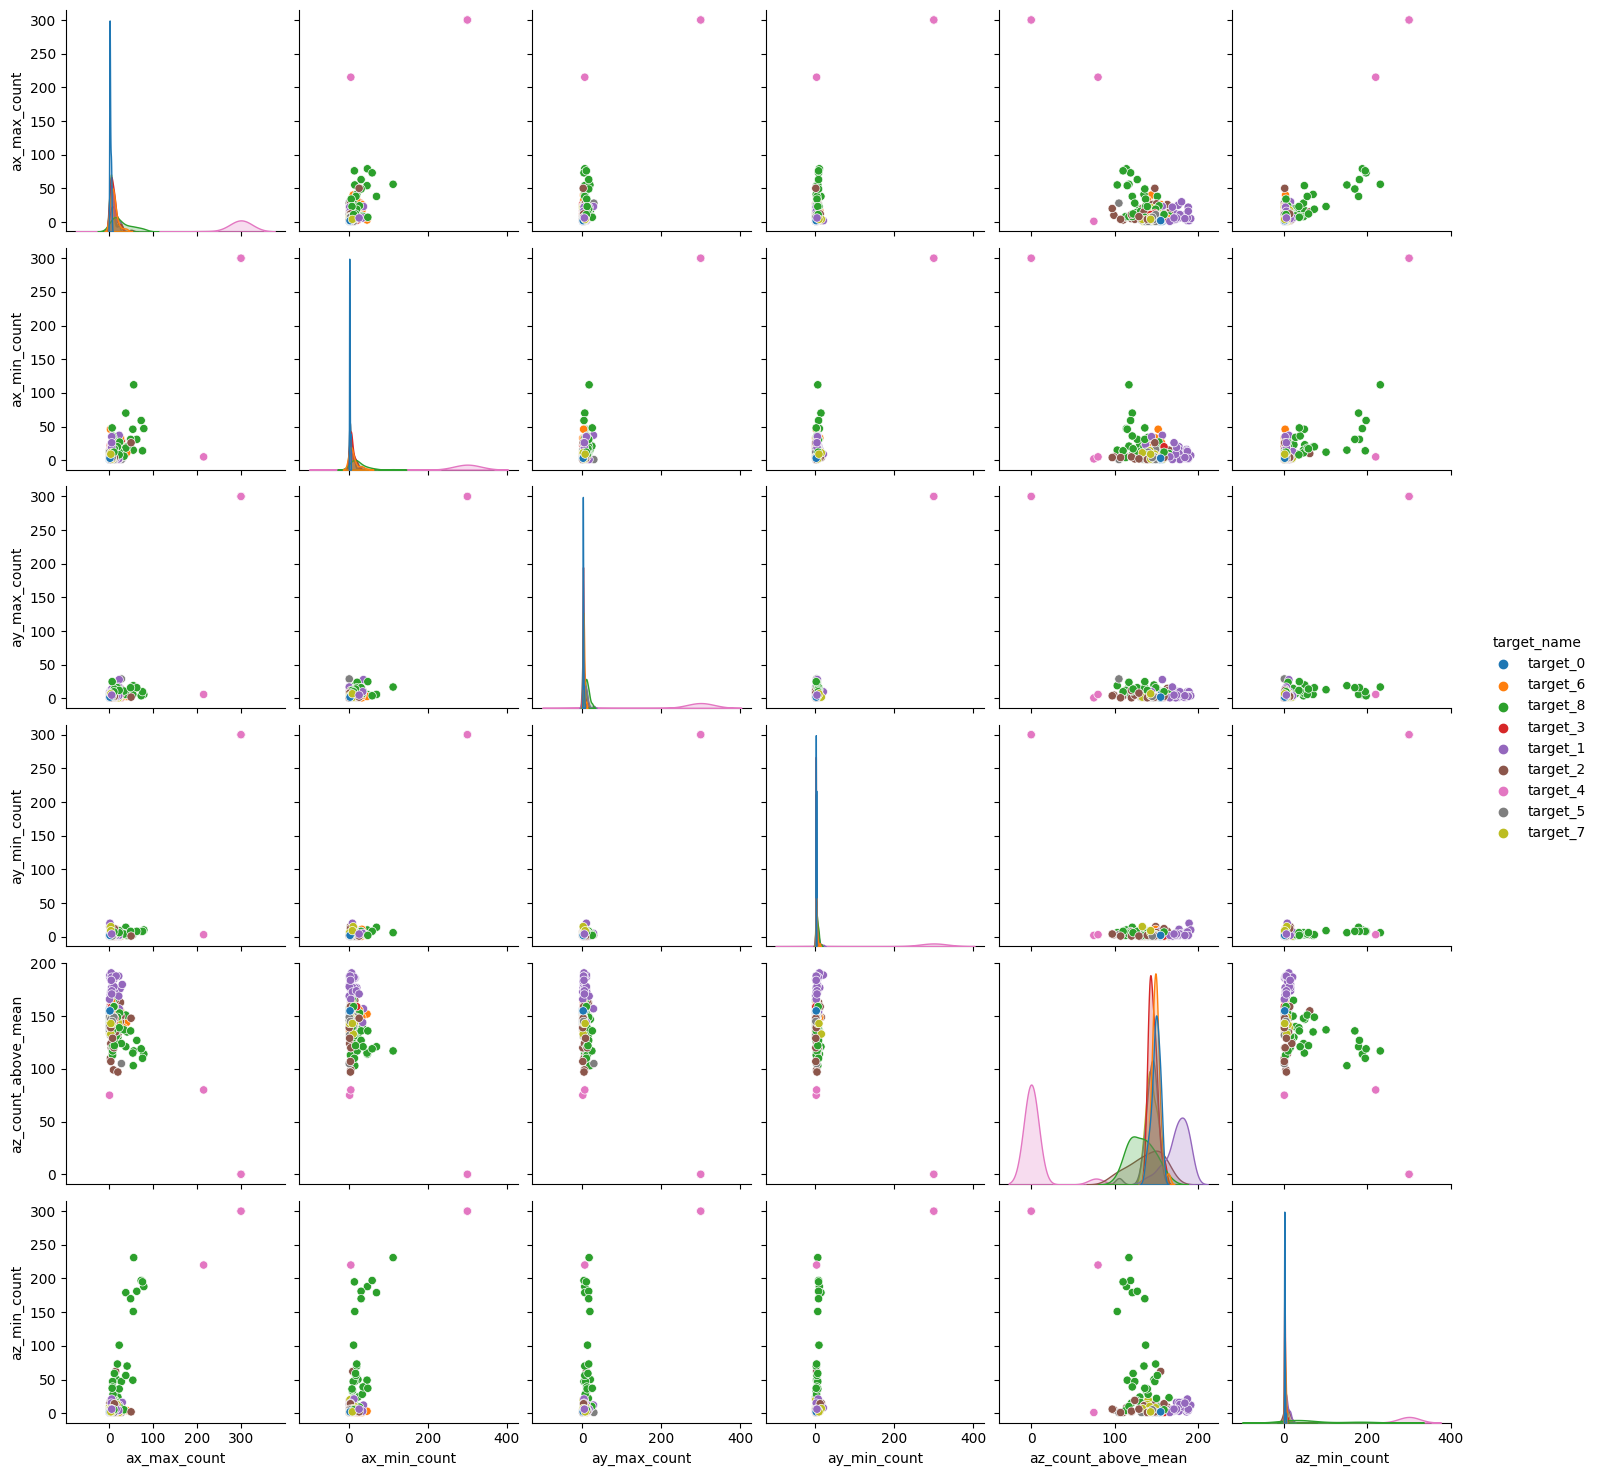

In [35]:
acc_dataset.plot.features_pairplot(n=300, k=6)
plt.show()

In [39]:
from everywhereml.sklearn.ensemble import RandomForestClassifier

imu_classifier = RandomForestClassifier(n_estimators=20, max_depth=20,n_jobs=-1)
imu_train, imu_test = acc_dataset.split(test_size=0.05)
imu_classifier.fit(imu_train)

print('Score on test set: %.2f' % imu_classifier.score(imu_test))

Score on test set: 1.00


In [40]:
imu_classifier.score(acc_dataset_eval)

0.6769982174908326

In [38]:
imu_train.df.describe()

,ax_maximum,ax_minimum,ax_abs_maximum,ax_abs_minimum,ax_mean,ax_abs_energy,ax_mean_abs_change,ax_cid_ce,ax_std,ax_var,...,az_count_below_mean,az_first_position_of_max,az_first_position_of_min,az_max_count,az_min_count,az_has_large_std,az_skew,az_kurtosis,az_variation_coefficient,target
count,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,...,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06,2.262750e+06
mean,7.262480e-01,5.509850e-01,7.262480e-01,5.509850e-01,6.375137e-01,4.158128e-01,2.048796e-02,1.474112e-03,3.827484e-02,2.448239e-03,...,1.285645e+02,1.367190e+02,1.365952e+02,4.599302e+01,4.180960e+01,1.884857e-01,-4.246569e-02,1.589926e+00,6.956179e-02,4.000839e+00
std,1.043410e-01,1.047714e-01,1.043410e-01,1.047714e-01,8.331146e-02,1.020941e-01,2.221033e-02,2.996242e-03,3.135723e-02,4.456345e-03,...,4.670680e+01,7.991263e+01,7.978424e+01,9.128438e+01,9.232362e+01,3.910996e-01,2.607670e-01,1.896490e+00,5.698136e-02,2.584870e+00
min,4.325340e-01,0.000000e+00,4.325340e-01,0.000000e+00,3.820097e-01,1.462475e-01,1.706040e-04,4.504392e-08,1.588798e-04,2.524280e-08,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.726085e+00,0.000000e+00,1.428820e-04,0.000000e+00
25%,6.765016e-01,4.936874e-01,6.765016e-01,4.936874e-01,6.300855e-01,4.009794e-01,5.029437e-03,5.608130e-05,1.766407e-02,3.120193e-04,...,1.320000e+02,6.800000e+01,6.800000e+01,2.000000e+00,1.000000e+00,0.000000e+00,-6.836604e-02,0.000000e+00,3.316339e-02,2.000000e+00
50%,7.152381e-01,5.721190e-01,7.152381e-01,5.721190e-01,6.441788e-01,4.155925e-01,1.322459e-02,3.371167e-04,3.003051e-02,9.018318e-04,...,1.440000e+02,1.360000e+02,1.360000e+02,7.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,1.554315e+00,5.557634e-02,4.000000e+00
75%,7.883055e-01,6.141714e-01,7.883055e-01,6.141714e-01,6.581897e-01,4.364335e-01,2.646882e-02,1.240658e-03,5.240207e-02,2.745977e-03,...,1.500000e+02,2.050000e+02,2.050000e+02,3.000000e+01,1.400000e+01,0.000000e+00,0.000000e+00,2.812953e+00,8.988412e-02,6.000000e+00
max,1.000000e+00,8.566265e-01,1.000000e+00,8.566265e-01,9.057891e-01,8.206600e-01,1.253372e-01,2.344334e-02,2.286833e-01,5.229605e-02,...,2.970000e+02,2.990000e+02,2.990000e+02,3.000000e+02,3.000000e+02,1.000000e+00,3.209517e+00,8.646022e+01,3.068476e-01,8.000000e+00


8. Train RandomForestClassifier